In [319]:
!pip install rouge-score

In [320]:
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import sys
import nltk.translate.bleu_score as ntbs  # BLEU scoring basics
import rouge_score.rouge_scorer as rouge_scorer  # ROUGE scoring basics
sys.path.insert(0, '../input/aida-metrics-functions')  # custom metrics implementation
import metrics as met  # custom metrics BLUE-1 pecsision and ROUGE-L recall
import json

In [321]:
#Import all the required libraries

# System Libraries 
import os, glob
from glob import glob
import pickle
from sys import getsizeof

# Date and Time 
import datetime,time

# Data manipulation
import numpy as np
import pandas as pd
import collections, random, re
from collections import Counter


# Model building 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


#Read/Display  images
from skimage import io
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

# tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model

from tqdm import tqdm

# Load Data

In [322]:
#Import the dataset and read the image into a seperate variable
INPUT_PATH = "../input/flickr8k/"
IMAGE_PATH = INPUT_PATH+'Images/'
CAPTIONS_FILE = INPUT_PATH+'captions.txt'
OUTPUT_IMAGE_PATH = "../working/Image/"

In [323]:
all_imgs = glob(IMAGE_PATH + '*.jpg')

1. Image are of different sizes, will resize them to (299, 299)

In [324]:
# Create a dataframe which summarizes the image, path & captions as a dataframe
# Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

captions_df = pd.read_csv(CAPTIONS_FILE)

pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption
print(captions_df.shape)
captions_df.head()

(40455, 2)


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [325]:
captions_df.nunique()

image      8091 
caption    40201
dtype: int64

In [326]:
# Reading captions file
file = open(CAPTIONS_FILE,'rb')
captions_txt = file.read().decode('utf-8')
file.close()
img_cap_corpus=captions_txt.split('\n')
img_cap_corpus.pop(0)## poping first line names of columns (image,caption)

'image,caption'

### Create a dataframe which summarizes the image, path & captions as a dataframe

In [327]:
datatxt = []
for line in img_cap_corpus:
    col = line.split(',')# Seperates columns image and caption
   
    if len(col)==1:
        continue
    w = col[0].split("_") # seperating image filename to extract the id 
   
    w[1] = IMAGE_PATH + col[0] # saving complete path of image file for building model
    datatxt.append(w + [col[1].lower()])

df= pd.DataFrame(datatxt,columns=['ID','Path','Captions'])
#df = df.reindex(columns =['ID','Path','Captions'])
uni_filenames= np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df.ID.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

In [328]:
all_img_id= df.ID#store all the image id 
all_img_vector= df.Path#store all the image path here
annotations= df.Captions#store all the captions here


print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(set(all_img_vector))))
print(annotations[:10])

Total captions present in the dataset: 40455
Total images present in the dataset: 8091
0    a child in a pink dress is climbing up a set of stairs in an entry way .              
1    a girl going into a wooden building .                                                 
2    a little girl climbing into a wooden playhouse .                                      
3    a little girl climbing the stairs to her playhouse .                                  
4    a little girl in a pink dress going into a wooden cabin .                             
5    a black dog and a spotted dog are fighting                                            
6    a black dog and a tri-colored dog playing with each other on the road .               
7    a black dog and a white dog with brown spots are staring at each other in the street .
8    two dogs of different breeds looking at each other on the road .                      
9    two dogs on pavement moving toward each other .                                 

### Create the vocabulary & the counter for the captions

In [329]:
uni_filenames = np.unique(df.ID.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df.ID.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

In [330]:
def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(captions):
      
    words = []

    for sentence in captions:
        sent_words = split_sentence(sentence)
        for word in sent_words: 
            words.append(word)
    return sorted(words)
    
vocab = generate_vocabulary(df.Captions)

#### Creating captions Counter

In [331]:
## Creating vocabulary of all words present in captions

vocabulary =  Counter(vocab)

df_word = pd.DataFrame.from_dict(vocabulary, orient='index')
#display(df_word.head(2))

df_word = df_word.sort_values(by=[0],ascending=False).reset_index()
#display(df_word.head(2))
df_word =df_word.rename(columns={'index':'word', 0:'count'})
#display(df_word.head(2))


In [332]:
df_word.head()

,word,count
0,a,61436
1,in,18193
2,the,17677
3,on,10369
4,is,9069


In [333]:
print(f'Vocab size = {len(vocabulary)}')

Vocab size = 8315


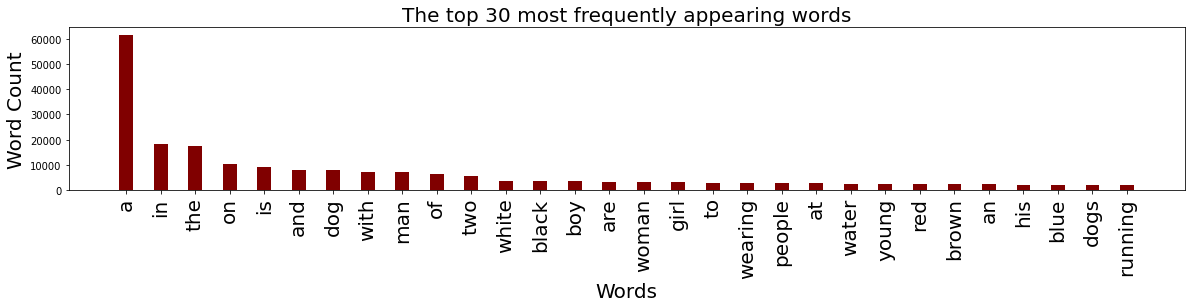

In [334]:
#Visualise the top 30 occuring words in the captions

def plthist(index,words,count, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(words,count,color='maroon', width =0.4)
    plt.xlabel("Words",  fontsize=20) 
    plt.ylabel("Word Count",rotation=90,fontsize=20) 
   # plt.yticks(fontsize=20)
    plt.xticks(index,words,rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()
    
words = list(df_word[:30].word)

count =list(df_word['count'][:30])
plthist(list(range(0,30)),words,count)

### 5.Create a list which contains all the captions & path

In [335]:
#Create a list which contains all the captions

#adding  the <start> & <end> token to all the captions 
df['Captions']=df.Captions.apply(lambda x : f"<start> {x} <end>")
annotations = df.Captions
# Find max length of sequence
max_length = max(df.Captions.apply(lambda x : len(x.split())))

#Create a list which contains all the path to the images
unique_img_path= sorted(set(all_img_vector))#write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))
print("Unique images present in the dataset: " + str(len(unique_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455
Unique images present in the dataset: 8091


## 2. Pre-Processing the captions
2.1 Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.2 Replace all other words with the unknown token "UNK" .

2.3 Create word-to-index and index-to-word mappings.

2.4 Pad all sequences to be the same length as the longest one.

### 2.1 Create the tokenizer
 Creating captions Counter, and dataframe of top 5000 frequently used words, for observation.

In [336]:
vocabulary =  Counter(vocab)
len(vocabulary)

8315

In [337]:
len(annotations), len(all_img_vector)

(40455, 40455)

In [338]:
def data_limiter(all_captions,all_img_vector):
    img_captions, img_name_vector = shuffle(all_captions,all_img_vector,random_state=42)
   # img_captions = img_captions[:num]
   # img_name_vector = img_name_vector[:num]
    return img_captions,img_name_vector

img_captions,all_img_vector = data_limiter(annotations,all_img_vector)

In [339]:
len(img_captions), len(all_img_vector)

(40455, 40455)

In [340]:
def tokenize_captions(top_cap,captions):
    special_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_freq_words,
                                                  oov_token="UNK",
                                                  filters=special_chars)
    tokenizer.fit_on_texts(captions)
    
    # Adding PAD to tokenizer list
    tokenizer.word_index['PAD'] = 0
    tokenizer.index_word[0] = 'PAD'   
   
    return tokenizer  
    

In [341]:
top_freq_words = 5000
tokenizer = tokenize_captions(top_freq_words,img_captions)
# Pad each vector to the max_length of the captions ^ store it to a vairable

# Create the tokenized vectors
cap_seqs = tokenizer.texts_to_sequences(img_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')

print("The shape of Caption vector is :" + str(cap_vector.shape))
print(cap_vector[:5])

The shape of Caption vector is :(40455, 35)
[[   3    2   55 1591  593    8 3971    2  224  123    2 1455    4    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3   14   28   32  499    7    6 1667  172    4    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   12    5  166    8   40    7    2   83   91   88   24    6
   458   75    6 3972    4    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2  882   15   10    8   33    7    6   42    4    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   3    2   43  378  728    4    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


In [342]:
# Maximum length of sequence 
max_length = max([len(cap) for cap in cap_seqs])
print("Shape of caption vector :", cap_vector.shape, )
print("Maximium length of sequence = ", max_length)

Shape of caption vector : (40455, 35)
Maximium length of sequence =  35


In [343]:
# Create word-to-index and index-to-word mappings.
def print_word_2_index(word):
    print("Word = {}, index = {}".format(word, tokenizer.word_index[word]))

          
print( "Word 2 index mapping")
print_word_2_index("<start>")
print_word_2_index("PAD")

Word 2 index mapping
Word = <start>, index = 3
Word = PAD, index = 0


In [344]:
# Create word-to-index and index-to-word mappings.
def print_index_2_word(index):
    print("Index = {}, Word = {}".format(index, tokenizer.index_word[index]))

          
print( "Index 2 word mapping")
print_index_2_word(5)
print_index_2_word(4999)

Index 2 word mapping
Index = 5, Word = in
Index = 4999, Word = salvar


In [345]:
# Word count of your tokenizer to see the Top 30 occuring words after text processing
word_count = tokenizer.word_counts
import operator
word_count = sorted(word_count.items(), key=operator.itemgetter(1),reverse=True)
for k,v in word_count[:30]:
    print (k,v)
    

a 61436
<start> 40455
<end> 40455
in 18193
the 17677
on 10369
is 9069
and 8066
dog 7958
with 7308
man 7172
of 6504
two 5550
white 3728
black 3641
boy 3534
are 3365
woman 3320
girl 3284
to 3008
wearing 2917
people 2837
at 2820
water 2683
young 2610
red 2571
brown 2484
an 2358
his 2255
blue 2136


## 3. Pre-processing the images

## Create the train & test data 

In [346]:
image_train, image_test, captions_train, captions_test = train_test_split(all_img_vector,cap_vector, test_size=0.2, random_state=42)

In [347]:
img_to_cap_vector = collections.defaultdict(list)

for img,cap in zip(all_img_vector,cap_vector):
    #print(img,cap)
    img_to_cap_vector[img].append(cap)

In [348]:
list(img_to_cap_vector.items())[2], len(img_to_cap_vector)*5, tokenizer.index_word[3], tokenizer.index_word[4], tokenizer.index_word[0]
#, print_index_2_word[4], print_index_2_word[0]

(('../input/flickr8k/Images/2053006423_6adf69ca67.jpg',
  [array([   3,    2,   12,    5,  166,    8,   40,    7,    2,   83,   91,
            88,   24,    6,  458,   75,    6, 3972,    4,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0], dtype=int32),
   array([  3,   2,  12,  91,  24,   6, 458,  13,   2, 128, 108,  40,   7,
            2,  83,   4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
   array([  3,  12,  11, 497,  36,   7,  22, 166,   9, 578, 639,  40,  11,
          176,   7,  30, 162,  91,  88, 244,   2, 108,   4,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
   array([  3,   2, 414,  12,  40,   7,   2,  83, 416,   2, 953,   4,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
   array([  3, 414,

In [349]:
def vector_to_sentence(caplist):
    captions_word =[]
    #print(caplist)
    for captions in caplist:
        #print(captions)
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word
        

## 4. Create the train & test data 

In [350]:
tf.random.set_seed(42)
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)
print(len(img_keys))
slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
print(len(img_name_train_keys), len(img_name_val_keys))

8091
6472 1619


In [351]:
image_train = []
captions_train = []
for imgt in img_name_train_keys:
    captions_len = len(img_to_cap_vector[imgt])
    #print(captions_len)
    image_train.extend([imgt] * captions_len)
    captions_train.extend(img_to_cap_vector[imgt])
    break

In [352]:
#4.1 Combine both images & captions to create the train & test dataset using tf.data.Dataset API. 
#Create the train-test spliit using 80-20 ratio & random state = 42
tf.random.set_seed(42)
# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]
#print(img_name_train_keys, img_name_val_keys)
image_train = []
captions_train = []
for imgt in img_name_train_keys:
    captions_len = len(img_to_cap_vector[imgt])
    #print(captions_len)
    image_train.extend([imgt] * captions_len)
    captions_train.extend(img_to_cap_vector[imgt])

image_test = []
captions_test = []
for imgtest in img_name_val_keys:
    captions_len = len(img_to_cap_vector[imgtest])
    image_test.extend([imgtest] * captions_len)
    captions_test.extend(img_to_cap_vector[imgtest])

In [353]:
img_name_train_keys[:5], img_to_cap_vector[img_name_train_keys[0]]

(['../input/flickr8k/Images/3373870185_f79163fa51.jpg',
  '../input/flickr8k/Images/2439154641_bbf985aa57.jpg',
  '../input/flickr8k/Images/319870744_0e0138d205.jpg',
  '../input/flickr8k/Images/2085557551_7a88d01d4e.jpg',
  '../input/flickr8k/Images/2902486045_6298eb22ef.jpg'],
 [array([   3,    2,   15,  263, 3047,   76,  732,    9,   68,   64,    6,
           25,  489, 1363,    4,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0], dtype=int32),
  array([   3,    2,  263, 3678,   47,   25,    4,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0], dtype=int32),
  array([  3,   2,  16,   9,  15, 263,   8, 284,  47,  25,   4,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,  

In [354]:
print("Image_train = {}, Captions_train = {}".format(len(image_train), len(captions_train)))

print("Image_test = {}, Captions_test = {}".format(len(image_test), len(captions_test)))

Image_train = 32360, Captions_train = 32360
Image_test = 8095, Captions_test = 8095


In [355]:
def get_file_name(filename):
    return (IMAGE_PATH + filename)

def vector_to_sentence(caplist):
    captions_word =[]
    #print(caplist)
    for captions in caplist:
        #print(captions)
        list_caption = list(captions)

        captions_word.append(' '.join(tokenizer.index_word[i] for i in list_caption))
    return captions_word

In [356]:
caplist_train = []
#for i in range(1,10):
captions_word = vector_to_sentence(list(captions_train[0:30]))
print(captions_word[28:])


['<start> a man jumping a dirt ramp on a bmx bike <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD', '<start> man riding a mountain bike doing a jump in the air <end> PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD']


In [357]:
DIR_IMAGE_FEATURES = '../input/aida-image-captioning/Images/'
# Load the numpy files
def map_func(img_name, cap):
    filename = DIR_IMAGE_FEATURES + img_name.decode('utf-8').split('/')[-1].replace('.jpg', '.npy')
    img_tensor = np.load(filename)
    return img_tensor, cap

In [358]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_dataset = tf.data.Dataset.from_tensor_slices((image_train, captions_train))
# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [359]:

test_dataset = tf.data.Dataset.from_tensor_slices((image_test, captions_test))
# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [360]:
train_img_batch, train_cap_batch = next(iter(train_dataset))
print(train_img_batch.shape) #(batch_size, 8*8,2048)
print(train_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 35)


In [361]:
test_img_batch, test_cap_batch = next(iter(test_dataset))
print(test_img_batch.shape) #(batch_size, 8*8,2048)
print(test_cap_batch.shape) #(batch_size, max_len)

(64, 64, 2048)
(64, 35)


In [362]:
train_img_batch[0][0], train_cap_batch[0]

(<tf.Tensor: shape=(2048,), dtype=float32, numpy=
 array([0.5298742 , 0.        , 1.2619808 , ..., 0.        , 0.        ,
        0.03653452], dtype=float32)>,
 <tf.Tensor: shape=(35,), dtype=int32, numpy=
 array([   3,   81,   17,    8, 1037,   73,   17,   21,  463,    2,   58,
         305,    5,    6,   70,    4,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0], dtype=int32)>)

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [363]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000


# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

embedding_dim = 256 
units = 512
vocab_size = top_freq_words + 1 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

## Encoder

## Attention Model

In [364]:
def padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(W1, W2, v, mask):
    matmul_W1W2 = tf.matmul(W1, W2, transpose_b=True)  # (..., seq_len_W1, seq_len_W2)
    dimW2 = tf.cast(tf.shape(W2)[-1], tf.float32)
    scaled_attention_logits = matmul_W1W2/ tf.math.sqrt(dimW2)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_W1, depth_v)

    return output, attention_weights

In [365]:
# Subclassing tensor layer to create multilayer Attention layer to be later  used in Attention Layer
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.W1 = tf.keras.layers.Dense(d_model)
        self.W2 = tf.keras.layers.Dense(d_model)
        self.Wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, W1, W2, mask=None):
        batch_size = tf.shape(q)[0]
        W1 = self.W1(W1)  # (batch_size, seq_len, d_model)
        W2 = self.W2(W2)  # (batch_size, seq_len, d_model)
        Wv = self.Wv(v)  # (batch_size, seq_len, d_model)

        W1 = self.split_heads(W1, batch_size)  # (batch_size, num_heads, seq_len_W1, depth)
        W2 = self.split_heads(W2, batch_size)  # (batch_size, num_heads, seq_len_W2, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(W1, W2, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

    def point_wise_feed_forward_network(d_model, dff):
        return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])  # (batch_size, seq_len, d_model)


# Encoder/Decoder Layers

In [366]:
#### Creating Encoder layer subclass keras.layers
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

In [367]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [368]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        return x, attention_weights

# Encoder

In [369]:
class Encoder(Model):
    def __init__(self,embedding_dim):
        super(Encoder, self).__init__()
        #Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embedding_dim)
        # shape after fc == (batch_size, 64, embedding_dim)
        #self.fc = tf.keras.layers.Dense(embedding_dim)
        #self.dropout = tf.keras.layers.Dropout(0.5,noise_shape=None,seed=None)
        
    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

## Decoder

In [370]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)#build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden,1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.nn.softmax(score,axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features  #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector,axis=1)# reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

In [371]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size,embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)#build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)#build your Dense layer
        self.attention = Attention_model(self.units)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features,hidden)#create your context vector & attention weights from attention model
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed =  self.embed(x)
        embed =  tf.concat([tf.expand_dims(context_vector,1),embed],axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed)# Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        x = self.d1(output)
        x = tf.reshape(x, (-1, x.shape[2])) # shape : (batch_size * max_length, hidden_size)
        x = self.d2(x) # shape : (batch_size * max_length, vocab_size)
        
        return x,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [372]:
encoder=Encoder(embedding_dim)
decoder=Decoder(embedding_dim, units, vocab_size)

In [373]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

features=encoder(train_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * train_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training

In [374]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True, reduction='none')#define your loss object
metric = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [375]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [376]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor,training =True)

        for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

          # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))
    metric(loss)    
    return loss, total_loss

In [377]:
@tf.function
def test_step(img_tensor, target):
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    features = encoder(img_tensor)
    for i in range(1, target.shape[1]):
          # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)
            predicted_id = tf.argmax(predictions[0])
            dec_input = tf.expand_dims([predicted_id] * target.shape[0] , 1)
   
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [378]:
def test_loss_cal(dataset):
    total_loss = 0

    for (batch,(img_tensor,target)) in enumerate(dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
   
    
    return total_loss/int(target.shape[1])

In [379]:
train_loss = tf.keras.metrics.Mean('train_loss',dtype=tf.float32)

In [380]:
#checkpoint_path_ckpt = "./checkpoints/train"
checkpoint_path_ckpt = '../input/brokendown-ckpt/checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer,
                           metrics=metric)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [381]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    print('Restoring from latest checkpoint')
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    
    ckpt.restore(ckpt_manager.latest_checkpoint)

Restoring from latest checkpoint


In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
    avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()
        
# save at the end
ckpt_manager.save()

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation

In [ ]:
def init_features(image):
    filename = DIR_IMAGE_FEATURES + image.split('/')[-1].replace('.jpg', '.npy')
    img_tensor_val = np.load(filename)
    
    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    return features,dec_input

In [ ]:
def make_prediction(image):
    hidden = decoder.init_state(batch_size=1)
    features,dec_input = init_features(image)
    
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,features,hidden) # get the output from decoder

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        # print(predicted_id)
        result.append(tokenizer.index_word[predicted_id])#map the id to the word from tokenizer and append the value to the result list

        if (tokenizer.index_word[predicted_id] == "<end>"):
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(image_test))
image = image_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in captions_test[rid] if i not in [0]])
result = make_prediction(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))

# BLEU-1 and ROUGE-L score

### Test set

In [382]:
actual = []
for i in range(0,len(image_test)-5,5):
    temp = []
    for j in range(i,i+5):
        real_caption = [tokenizer.index_word[k]
                        for k in captions_test[j] if k not in [0]]
        temp.append(real_caption)
    actual.append(temp)

In [383]:
pred = []
for i in tqdm(range(0,len(image_test)-5,5)):
    image = image_test[i]
    result = make_prediction(image)
    result.insert(0,'<start>')
    pred.append(result)

100%|██████████| 1618/1618 [02:17<00:00, 11.78it/s]


In [384]:
real_dict, pred_dict = {}, {}
for i, (reals, preds) in enumerate(zip(actual, pred)):    
    real_dict[i] = [' '.join(x) for x in reals]
    pred_dict[i] = ' '.join(preds) 

In [385]:
rouge_l_test, bleu_1_test = met.evaluate(real_dict, pred_dict)
print(f"Metrics for Testset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")

Metrics for Testset:
ROUGE-L recall:    45.37%
BLEU-1 precision:  44.64%


### Train set

In [ ]:
actual = []
for i in range(0,len(image_train)-5,5):
    temp = []
    for j in range(i,i+5):
        real_caption = [tokenizer.index_word[k]
                        for k in captions_train[j] if k not in [0]]
        temp.append(real_caption)
    actual.append(temp)
    
pred = []
for i in tqdm(range(0,len(image_train)-5,5)):
    image = image_train[i]
    result = make_prediction(image)
    result.insert(0,'<start>')
    pred.append(result)
    
real_dict, pred_dict = {}, {}
for i, (reals, preds) in enumerate(zip(actual, pred)):    
    real_dict[i] = [' '.join(x) for x in reals]
    pred_dict[i] = ' '.join(preds) 

 19%|█▉        | 1229/6471 [01:45<07:49, 11.17it/s]

In [ ]:
rouge_l_train, bleu_1_train = met.evaluate(real_dict, pred_dict)
print(f"Metrics for Trainset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")